# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-25

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math, sys

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [1]:
# Importing dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import ipympl
from pathlib import Path
import math
import sys
sys.path.append(r"..")
import microspot_util as msu
import microspot_util.plots as plots
%matplotlib widget


2023-10-18 15:16:41.667 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-18 15:16:41.674 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-18 15:16:41.677 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-18 15:16:41.680 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager
2023-10-18 15:16:41.686 WARNING streamlit.runtime.caching.cache_data_api: No runtime found, using MemoryCacheStorageManager


## User Input

In [2]:
inputfile=Path(r"../test_images/edge_halo.tif")
outputfolder=Path(r"../output")

first_spot="B1"
last_spot="Q20"

ctrl_rows=["A","J"]
ctrl_cols=[]

### Extracting Information from User Input

In [3]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=msu.conv_gridinfo(first_spot,last_spot,row_conv)

2023-10-18 15:16:41.943 
  command:

    streamlit run /home/nesiron/anaconda3/envs/petras/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2023-10-18 15:16:41.947 No runtime found, using MemoryCacheStorageManager


## Loading the Image File

2023-10-18 15:16:41.973 No runtime found, using MemoryCacheStorageManager


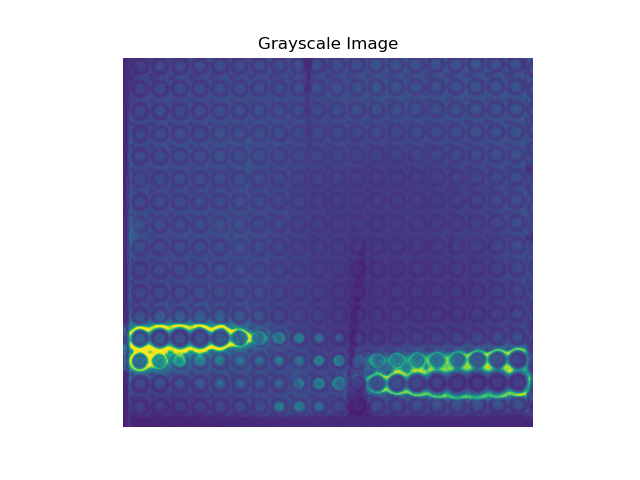

In [4]:
# Load and prepare raw image file.
raw_img=msu.prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image");

## Inital Spot and Grid detection

2023-10-18 15:16:43.766 No runtime found, using MemoryCacheStorageManager
2023-10-18 15:16:53.485 No runtime found, using MemoryCacheStorageManager


Spot at Coordinates (1610, 1983) could not be drawn: Out of Bounds.


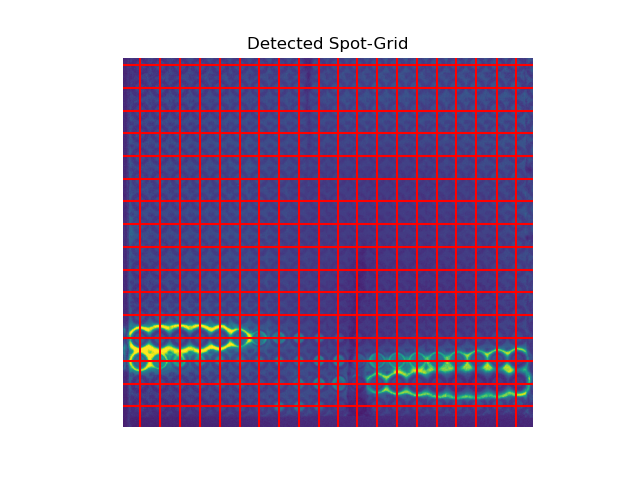

In [5]:
# Inital spot-detection.
init_spots=msu.spot.detect(raw_img,grid_props["spot_nr"])

# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=msu.gridline.detect(dot_img)
hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
plots.plot_grid(fig,ax,raw_img,hor_line+vert_line)

## Spot Correction, Sorting and Intensity Determination

In [6]:
# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=10:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot.
for g_point in grid_points:
    if g_point.min_dist>10:
        msu.spot.backfill(corr_spots,g_point.x,g_point.y)

sort_spots=msu.spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])

for s in sort_spots:
    s.get_intensity(raw_img)

    if s.row_name in ctrl_rows or s.col in ctrl_cols:
        s.type="Control"

## Halo Detection

In [7]:
# Detect Halos using the halo.detect method.
halos=msu.halo.detect(raw_img)

# Assign halos to their spot.
for s in sort_spots:
    s.assign_halo(halos)


2023-10-18 15:16:55.707 No runtime found, using MemoryCacheStorageManager


## Normalization using Controls

In [8]:
# If controls are present, normalize the spot intensities 
if len(ctrl_rows) != 0 or len(ctrl_cols) != 0:
    msu.spot.normalize(sort_spots)

,row,row_name,column,type,x_coord,y_coord,radius,halo,spot_intensity,norm_intensity,note,RT
0,2,B,1,Sample,93,46,23,NaN,0.560014,0.982770,Initial Detection,NaN
1,2,B,2,Sample,199,47,23,NaN,0.577184,1.012902,Initial Detection,NaN
2,2,B,3,Sample,303,40,25,NaN,0.573282,1.006055,Backfilled,NaN
3,2,B,4,Sample,411,48,24,NaN,0.580311,1.018390,Initial Detection,NaN
4,2,B,5,Sample,519,47,24,NaN,0.584947,1.026526,Initial Detection,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
315,17,Q,16,Sample,1684,1869,25,NaN,0.590676,1.036579,Initial Detection,NaN
316,17,Q,17,Sample,1793,1869,25,NaN,0.593319,1.041217,Initial Detection,NaN
317,17,Q,18,Sample,1900,1869,24,NaN,0.592694,1.040121,Initial Detection,NaN
318,17,Q,19,Sample,2014,1868,20,NaN,0.595338,1.044761,Initial Detection,NaN


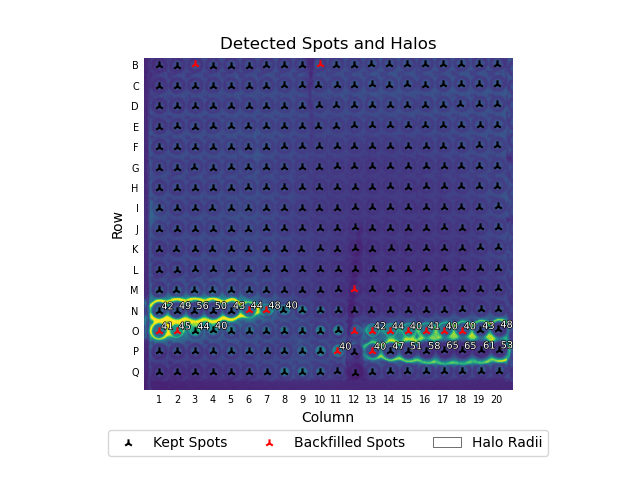

In [9]:
# Display the corrected and sorted spotlist.
sort_spot=msu.spot.create_df(sort_spots)

fig,ax=plt.subplots()
plots.plot_result(fig,ax,raw_img,sort_spot,grid_props)

sort_spot


## Heatmap

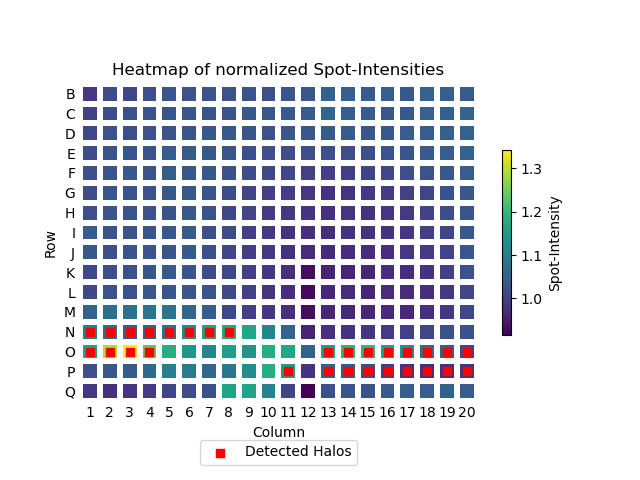

In [10]:
fig,ax=plt.subplots()
plots.plot_heatmap(fig,ax,sort_spot,grid_props,norm_data=True)

## Save Results

In [11]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spot.to_csv(outputfile)

,row,row_name,column,type,x_coord,y_coord,radius,halo,spot_intensity,norm_intensity,note,RT
0,2,B,1,Sample,93,46,23,NaN,0.560014,0.982770,Initial Detection,NaN
1,2,B,2,Sample,199,47,23,NaN,0.577184,1.012902,Initial Detection,NaN
2,2,B,3,Sample,303,40,25,NaN,0.573282,1.006055,Backfilled,NaN
3,2,B,4,Sample,411,48,24,NaN,0.580311,1.018390,Initial Detection,NaN
4,2,B,5,Sample,519,47,24,NaN,0.584947,1.026526,Initial Detection,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
315,17,Q,16,Sample,1684,1869,25,NaN,0.590676,1.036579,Initial Detection,NaN
316,17,Q,17,Sample,1793,1869,25,NaN,0.593319,1.041217,Initial Detection,NaN
317,17,Q,18,Sample,1900,1869,24,NaN,0.592694,1.040121,Initial Detection,NaN
318,17,Q,19,Sample,2014,1868,20,NaN,0.595338,1.044761,Initial Detection,NaN


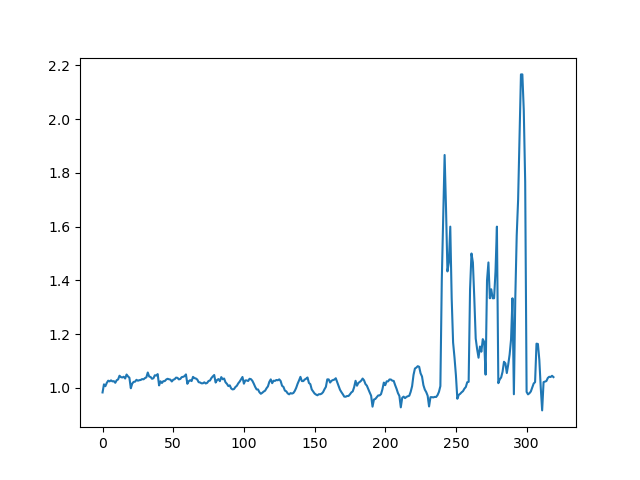

In [13]:
df=msu.spot.create_df(sort_spots)

df.loc[df["halo"]>0,"norm_intensity"]=df["halo"]/30
